In [1]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pathlib import Path

from dotenv import load_dotenv
from stable_baselines3 import PPO
from envionments.threshold_refinement import ThresholdRefinementEnv
from utility.dataset import load_pascal_voc2007, load_custom_dataset
from utility.torch_utils import get_default_device
from utility.logging_utils import setup_logging

# Load .env but do not override pre-set values in this runtime
load_dotenv(".env", override=False)
setup_logging()

# Defaults for more credible runs and GPU usage (Metal on macOS)
os.environ.setdefault("RL_DATA_LIMIT", "1000")
os.environ.setdefault("RL_TOTAL_TIMESTEPS", "50000")
os.environ.setdefault("RL_EVAL_EPISODES", "10")
os.environ.setdefault("RL_LEARNING_RATE", "3e-4")
os.environ.setdefault("RL_DEVICE", "cpu")
os.environ.setdefault("DETECTOR_DEVICE", "mps")

VOC_ROOT = os.getenv("VOC_ROOT", "data/voc")
IMAGE_DIR = os.getenv("IMAGE_DIR")
LABEL_DIR = os.getenv("LABEL_DIR")
DATA_LIMIT = int(os.getenv("RL_DATA_LIMIT", "1000"))
TOTAL_TIMESTEPS = int(os.getenv("RL_TOTAL_TIMESTEPS", "50000"))
LEARNING_RATE = float(os.getenv("RL_LEARNING_RATE", "3e-4"))
MODEL_PATH = os.getenv("RL_MODEL_PATH", "rl_threshold_tuner.zip")

POLICY_DEVICE = get_default_device(env_var="RL_DEVICE")
DETECTOR_DEVICE = get_default_device(env_var="DETECTOR_DEVICE")

if IMAGE_DIR:
    dataset = load_custom_dataset(
        IMAGE_DIR,
        LABEL_DIR or IMAGE_DIR,
        annotation_format="yolo_txt",
        limit=DATA_LIMIT,
    )
else:
    dataset = load_pascal_voc2007(
        VOC_ROOT, image_set="trainval", limit=DATA_LIMIT, download=True
    )

env = ThresholdRefinementEnv(dataset, device=POLICY_DEVICE, detector_device=DETECTOR_DEVICE)

if Path(MODEL_PATH).exists():
    try:
        model = PPO.load(MODEL_PATH, device=POLICY_DEVICE)
        model.set_env(env)
        print(f"Loaded existing model from {MODEL_PATH}")
    except ValueError as err:
        print(f"Model at {MODEL_PATH} incompatible with current env ({err}); retraining.")
        model = PPO("MlpPolicy", env, verbose=1, learning_rate=LEARNING_RATE, n_steps=512, device=POLICY_DEVICE)
        model.learn(total_timesteps=TOTAL_TIMESTEPS)
        model.save(MODEL_PATH)
        print(f"Trained and saved model to {MODEL_PATH}")
else:
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=LEARNING_RATE, n_steps=512, device=POLICY_DEVICE)
    model.learn(total_timesteps=TOTAL_TIMESTEPS)
    model.save(MODEL_PATH)
    print(f"Trained and saved model to {MODEL_PATH}")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded existing model from rl_threshold_tuner.zip


2025-12-07 14:48:45,495 | INFO | utility.evaluation | Evaluation summary: episodes=10 mean_final_iou=0.6798 std_final_iou=0.3693 mean_return=0.6798 mean_steps=3.60


Episodes: 10
Mean final IoU: 0.6798 +/- 0.3693
Mean return: 0.6798
Mean steps: 3.60
Per-episode final IoUs: [0.5537, 0.9459, 0.0, 0.9455, 0.9471, 0.869, 0.9564, 0.5971, 0.0, 0.9828]


<Axes: title={'center': 'Threshold trajectory per evaluation episode'}, xlabel='Step', ylabel='Confidence threshold'>

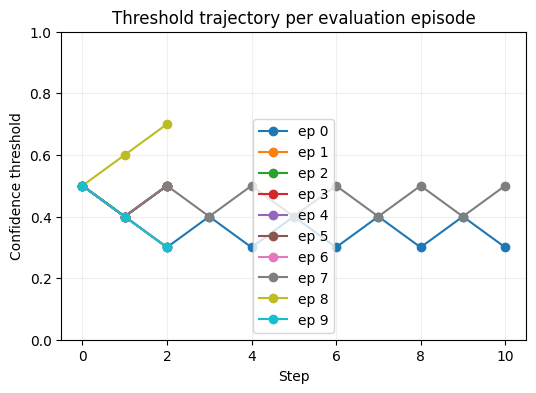

In [3]:
import os

from dotenv import load_dotenv
from utility.evaluation import evaluate_policy, summarize_stats, plot_threshold_trajectories

load_dotenv(".env", override=False)
os.environ.setdefault("RL_EVAL_EPISODES", "10")
EVAL_EPISODES = int(os.getenv("RL_EVAL_EPISODES", "10"))

stats = evaluate_policy(
    model,
    dataset,
    episodes=EVAL_EPISODES,
    device=POLICY_DEVICE,
    detector_device=DETECTOR_DEVICE,
)
summary = summarize_stats(stats)
print("Episodes:", summary["episodes"])
print(f"Mean final IoU: {summary['mean_final_iou']:.4f} +/- {summary['std_final_iou']:.4f}")
print(f"Mean return: {summary['mean_return']:.4f}")
print(f"Mean steps: {summary['mean_steps']:.2f}")
print("Per-episode final IoUs:", [round(s.final_iou, 4) for s in stats])

plot_threshold_trajectories(stats)


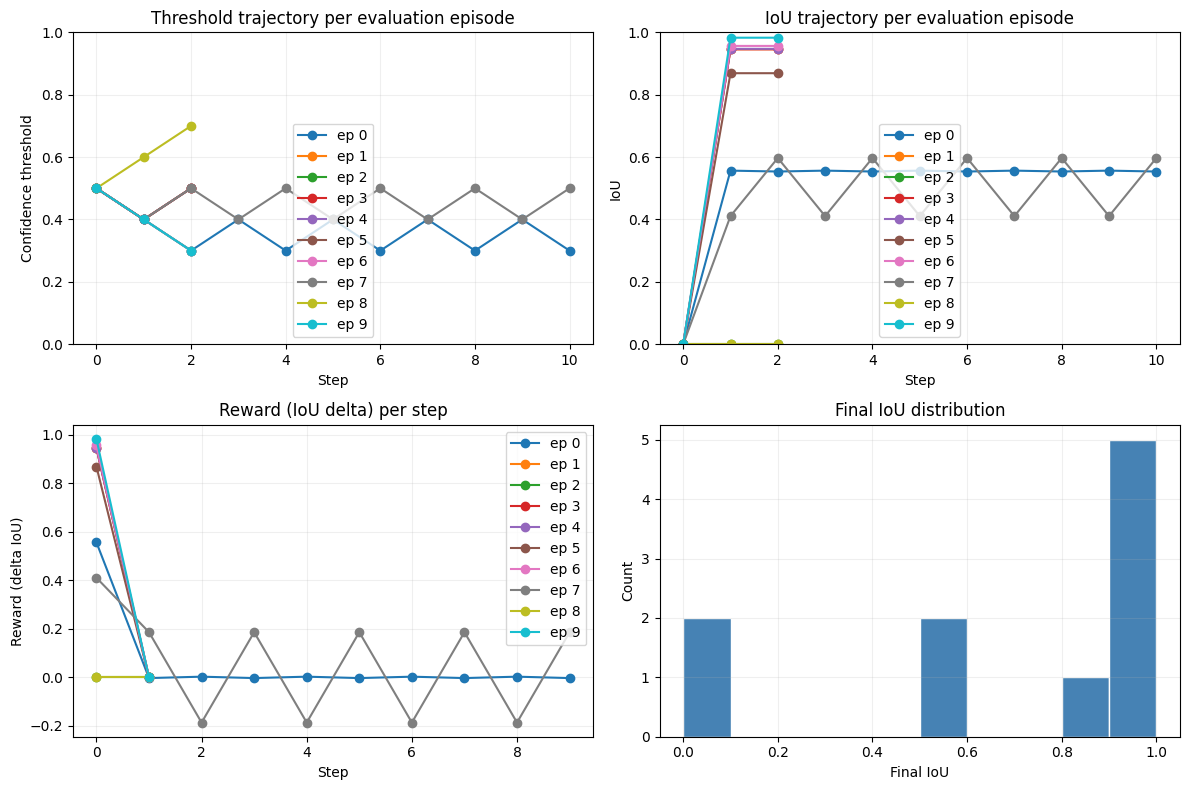

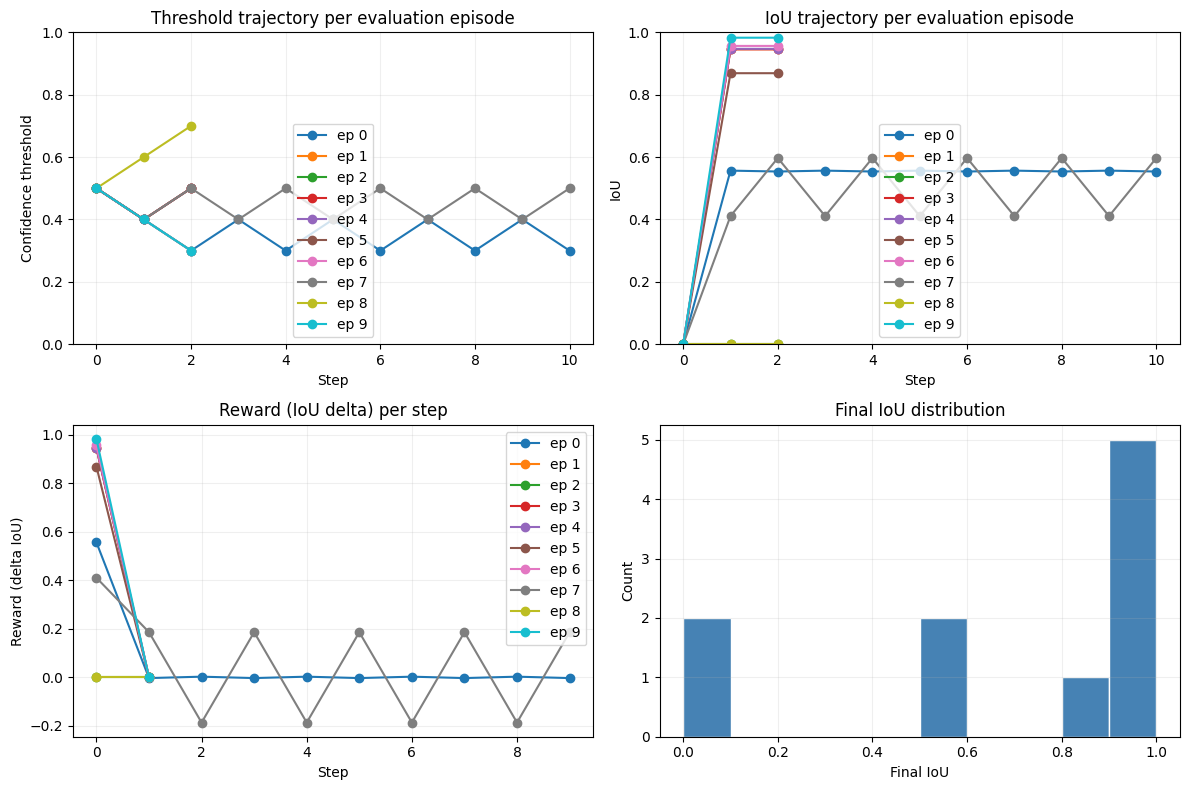

In [4]:
import matplotlib.pyplot as plt
from utility.evaluation import (
    plot_threshold_trajectories,
    plot_iou_trajectories,
    plot_reward_trajectories,
    plot_final_iou_histogram,
)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_threshold_trajectories(stats, ax=axes[0, 0])
plot_iou_trajectories(stats, ax=axes[0, 1])
plot_reward_trajectories(stats, ax=axes[1, 0])
plot_final_iou_histogram(stats, ax=axes[1, 1])
plt.tight_layout()
fig


## Compare RL policy vs baseline YOLO

Run the saved PPO checkpoint against fixed-threshold YOLOv8n.


In [ ]:
# import os
# import json
# from dotenv import load_dotenv
# from utility.model_comparison import compare_models

# # Lightweight comparison controls (tune here instead of editing code)
# load_dotenv('.env', override=False)
# COMPARE_DATA_LIMIT = int(os.getenv('COMPARE_DATA_LIMIT', '100'))
# COMPARE_EPISODES = int(os.getenv('COMPARE_EPISODES', '3'))
# COMPARE_THRESHOLDS = [float(t) for t in os.getenv('COMPARE_THRESHOLDS', '0.3,0.5,0.7').split(',')]

# comparison = compare_models(
#     model_path=MODEL_PATH,
#     episodes=COMPARE_EPISODES,
#     dataset_limit=COMPARE_DATA_LIMIT,
#     thresholds=COMPARE_THRESHOLDS,
# )
# print(json.dumps(comparison, indent=2))


2025-12-07 14:48:45,898 | INFO | utility.model_comparison | Using VOC2007 root=./data/voc limit=100
2025-12-07 14:48:45,898 | INFO | utility.model_comparison | Running comparison on dataset=voc2007(./data/voc) episodes=3 thresholds=[0.3, 0.5, 0.7]
2025-12-07 14:48:46,884 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.6651 std_final_iou=0.2182 mean_return=0.6651 mean_steps=7.33
2025-12-07 14:48:46,956 | INFO | utility.model_comparison | Evaluating baseline at threshold=0.30



0: 480x640 3 chairs, 1 dining table, 21.4ms
Speed: 1.0ms preprocess, 21.4ms inference, 25.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 car, 17.9ms
Speed: 1.3ms preprocess, 17.9ms inference, 3.4ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 horse, 23.5ms
Speed: 1.3ms preprocess, 23.5ms inference, 20.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bus, 24.3ms
Speed: 1.5ms preprocess, 24.3ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 bicycle, 1 traffic light, 124.3ms
Speed: 4.5ms preprocess, 124.3ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 car, 1 horse, 138.5ms
Speed: 4.4ms preprocess, 138.5ms inference, 30.1ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 2 dogs, 23.3ms
Speed: 1.3ms preprocess, 23.3ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 car, 2 motorcycles, 27.0ms
Speed: 1.3ms preprocess, 27.

KeyboardInterrupt: 